# Paquetes

In [1]:
import read_data as imp
import numpy as np
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
import Alphas101 as Alphas

import matplotlib as plt
from math import sqrt
from yellowbrick.cluster import KElbowVisualizer
from statistics import stdev
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical
from sklearn.metrics import adjusted_rand_score
import random

'''Algos'''
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape, TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import AgglomerativeClustering
from pyclustering.cluster.kmedoids import kmedoids
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from pyclustering.cluster.clarans import clarans;
from pyclustering.utils import timedcall;
from sklearn import datasets
import operator
import calendar
import itertools as it

import time

import warnings
warnings.filterwarnings("ignore")

C:\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.


# Funciones Auxiliares

### TSKmeans - dtw

In [2]:
def strategy_tskmeans_dtw (df, n =252, K =4, metric = "dtw"):
    
    #  metric : {“euclidean”, “dtw”, “softdtw”} (default: “euclidean”)
    
    X = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(df.T.values)

    
    
    km = TimeSeriesKMeans(n_clusters=4, max_iter=200, n_init=200,tol = 1e-8, \
                      metric= metric, verbose=1, random_state=2019).fit(X)

    index = list(range(len(df.columns)))
    columns = ['strategies', 'clusters', 'selection']

    results = pd.DataFrame(index=index, columns=columns)

    results['clusters'] = km.labels_
    results['strategies'] = df.columns

    sharpeclusters = []
    dfaux = df.tail(n)
    for i in range(results['clusters'].nunique()):
        l = results.loc[results['clusters'] == i].index.values.astype(int).tolist()
        dfexp = dfaux.pct_change().iloc[:, l].sum(axis=1, skipna=True)
        r = dfexp.mean()
        s = stdev(dfexp)

        sharpeclusters.append(r / s)
    sharpeclusters = np.asanyarray(sharpeclusters)

    selection = sharpeclusters.argmax()
    cond = results['clusters'] == selection

    results['selection'] = np.where(cond, 1, 0)

    return results['strategies'][results['selection'] == 1].values.tolist()

# Backtesting

In [3]:
Estrategias = pd.read_csv('Rentabilidad de estrategias base 100.csv')
Estrategias.set_index('Date', inplace = True)
Estrategias.index = pd.to_datetime(Estrategias.index)

Est_Returns = Estrategias.pct_change().fillna(0)

In [4]:
Initial_Date = pd.to_datetime('2014-01-01')

Rebalancing_dates = []
curr_month = Initial_Date.month

the_start = np.where(Initial_Date == Estrategias.index)[0].tolist()[0]

for i in range((the_start+1), len(Estrategias.index)):
    if Estrategias.index[i].month != curr_month:
        Rebalancing_dates.append(Estrategias.index[i-1])
        curr_month = Estrategias.index[i].month

## Calculating the factors over time

In [5]:
Clustering_Returns = pd.DataFrame(index = Estrategias.index[Estrategias.index >= Initial_Date],
                                  columns = ['TSKM-D'])

TSKMD = []

Memory_time_window = 126

for i in Estrategias.index[Estrategias.index >= Initial_Date]:
            
    if i in Rebalancing_dates:
        
        end = np.where(i == Estrategias.index)[0].tolist()[0]
        ini = end - Memory_time_window
        
        # update Baskets
        
        TSKMD = strategy_tskmeans_dtw(Estrategias.iloc[ini:end,:])
        
        # Return calculus
        
        Clustering_Returns.loc[i,'TSKM-D'] = Est_Returns.loc[i,TSKMD].sum()
        
    else:
        
        Clustering_Returns.loc[i,'TSKM-D'] = Est_Returns.loc[i,TSKMD].sum()

Init 1
6.986 --> 3.995 --> 3.262 --> 3.262 --> 
Init 2
6.346 --> 3.080 --> 3.080 --> 
Init 3
5.774 --> 3.135 --> 3.135 --> 
Init 4
5.444 --> 3.383 --> 3.383 --> 
Init 5
7.790 --> 4.150 --> 3.282 --> 3.282 --> 
Init 6
7.413 --> 4.400 --> 4.400 --> 
Init 7
6.223 --> 3.937 --> 3.214 --> 3.214 --> 
Init 8
7.273 --> 4.372 --> 4.372 --> 
Init 9
5.762 --> 3.067 --> 3.067 --> 
Init 10
5.580 --> 3.447 --> 3.447 --> 
Init 11
7.439 --> 3.559 --> 3.559 --> 
Init 12
6.939 --> 4.127 --> 4.127 --> 
Init 13
7.615 --> 4.166 --> 4.166 --> 
Init 14
8.599 --> 4.235 --> 4.235 --> 
Init 15
6.398 --> 4.001 --> 3.302 --> 3.302 --> 
Init 16
5.774 --> 3.038 --> 3.038 --> 
Init 17
6.482 --> 4.277 --> 4.277 --> 
Init 18
6.077 --> 3.463 --> 3.463 --> 
Init 19
7.337 --> 4.313 --> 4.313 --> 
Init 20
5.723 --> 3.450 --> 3.450 --> 
Init 21
7.128 --> 3.367 --> 3.367 --> 
Init 22
5.203 --> 3.392 --> 3.392 --> 
Init 23
7.087 --> 4.183 --> 4.183 --> 
Init 24
6.365 --> 4.013 --> 3.274 --> 3.274 --> 
Init 25
5.588 --> 3.101

6.815 --> 4.077 --> 3.313 --> 3.313 --> 
Init 196
7.500 --> 4.092 --> 3.224 --> 3.224 --> 
Init 197
5.318 --> 3.463 --> 3.463 --> 
Init 198
6.887 --> 4.127 --> 4.019 --> 4.019 --> 
Init 199
7.029 --> 4.081 --> 4.081 --> 
Init 200
7.089 --> 4.154 --> 4.154 --> 
Init 1
6.984 --> 4.498 --> 4.498 --> 
Init 2
6.948 --> 3.514 --> 3.514 --> 
Init 3
4.794 --> 3.240 --> 3.240 --> 
Init 4
6.684 --> 3.790 --> 3.790 --> 
Init 5
8.223 --> 3.628 --> 3.628 --> 
Init 6
7.151 --> 4.013 --> 4.013 --> 
Init 7
4.658 --> 3.229 --> 3.229 --> 
Init 8
7.283 --> 3.649 --> 3.649 --> 
Init 9
5.429 --> 3.276 --> 3.276 --> 
Init 10
4.776 --> 3.265 --> 3.265 --> 
Init 11
7.054 --> 4.778 --> 4.778 --> 
Init 12
6.753 --> 3.655 --> 3.655 --> 
Init 13
6.638 --> 3.624 --> 3.624 --> 
Init 14
8.777 --> 5.169 --> 5.169 --> 
Init 15
4.649 --> 3.299 --> 3.299 --> 
Init 16
4.872 --> 3.239 --> 3.239 --> 
Init 17
6.637 --> 3.627 --> 3.627 --> 
Init 18
6.997 --> 3.526 --> 3.526 --> 
Init 19
4.616 --> 3.311 --> 3.311 --> 
Init 20

6.984 --> 4.535 --> 4.535 --> 
Init 199
6.050 --> 3.259 --> 3.259 --> 
Init 200
10.951 --> 5.655 --> 5.655 --> 
Init 1
7.035 --> 4.423 --> 4.423 --> 
Init 2
7.224 --> 4.083 --> 4.083 --> 
Init 3
6.976 --> 4.411 --> 4.411 --> 
Init 4
7.632 --> 3.977 --> 3.977 --> 
Init 5
7.905 --> 4.083 --> 4.083 --> 
Init 6
7.146 --> 4.622 --> 4.467 --> 4.467 --> 
Init 7
6.827 --> 4.099 --> 4.099 --> 
Init 8
6.989 --> 4.008 --> 4.008 --> 
Init 9
7.304 --> 4.010 --> 4.010 --> 
Init 10
7.506 --> 4.512 --> 4.512 --> 
Init 11
10.561 --> 6.038 --> 5.869 --> 5.869 --> 
Init 12
8.778 --> 4.554 --> 4.554 --> 
Init 13
8.208 --> 4.557 --> 4.488 --> 4.446 --> 4.446 --> 
Init 14
9.789 --> 4.395 --> 4.395 --> 
Init 15
7.411 --> 4.148 --> 4.148 --> 
Init 16
6.915 --> 3.937 --> 3.937 --> 
Init 17
7.111 --> 4.465 --> 4.465 --> 
Init 18
8.590 --> 4.536 --> 4.536 --> 
Init 19
7.208 --> 4.178 --> 4.178 --> 
Init 20
6.987 --> 3.948 --> 3.948 --> 
Init 21
7.081 --> 4.326 --> 4.326 --> 
Init 22
6.919 --> 3.983 --> 3.983 -->

12.393 --> 7.384 --> 7.384 --> 
Init 3
11.151 --> 6.315 --> 6.315 --> 
Init 4
11.994 --> 7.106 --> 7.106 --> 
Init 5
11.134 --> 6.986 --> 6.986 --> 
Init 6
12.613 --> 6.981 --> 6.981 --> 
Init 7
11.787 --> 6.751 --> 6.751 --> 
Init 8
11.603 --> 6.020 --> 6.020 --> 
Init 9
13.218 --> 6.484 --> 6.484 --> 
Init 10
10.711 --> 6.240 --> 6.240 --> 
Init 11
10.641 --> 6.490 --> 6.490 --> 
Init 12
12.023 --> 6.467 --> 6.467 --> 
Init 13
12.412 --> 6.316 --> 6.316 --> 
Init 14
11.346 --> 6.695 --> 6.695 --> 
Init 15
12.859 --> 6.717 --> 6.577 --> 6.577 --> 
Init 16
11.234 --> 6.487 --> 6.291 --> 6.291 --> 
Init 17
12.473 --> 7.355 --> 7.281 --> 7.281 --> 
Init 18
11.146 --> 6.038 --> 6.038 --> 
Init 19
11.775 --> 6.372 --> 6.372 --> 
Init 20
13.427 --> 7.711 --> 7.711 --> 
Init 21
11.923 --> 7.010 --> 6.946 --> 6.946 --> 
Init 22
11.632 --> 6.450 --> 6.450 --> 
Init 23
14.779 --> 7.954 --> 7.954 --> 
Init 24
11.614 --> 6.676 --> 6.676 --> 
Init 25
12.870 --> 6.195 --> 6.195 --> 
Init 26
12.817 

11.318 --> 6.430 --> 6.430 --> 
Init 193
12.417 --> 7.429 --> 7.429 --> 
Init 194
14.792 --> 6.819 --> 6.819 --> 
Init 195
12.274 --> 7.780 --> 7.710 --> 7.710 --> 
Init 196
11.780 --> 6.955 --> 6.955 --> 
Init 197
12.970 --> 7.121 --> 7.121 --> 
Init 198
12.028 --> 6.453 --> 6.453 --> 
Init 199
15.960 --> 6.264 --> 5.988 --> 5.988 --> 
Init 200
12.254 --> 6.585 --> 6.585 --> 
Init 1
8.290 --> 5.306 --> 5.306 --> 
Init 2
8.889 --> 5.661 --> 5.661 --> 
Init 3
8.524 --> 5.664 --> 5.664 --> 
Init 4
10.004 --> 5.669 --> 5.669 --> 
Init 5
8.545 --> 5.014 --> 5.014 --> 
Init 6
10.640 --> 5.859 --> 5.859 --> 
Init 7
7.735 --> 5.039 --> 5.039 --> 
Init 8
9.902 --> 6.206 --> 6.206 --> 
Init 9
8.940 --> 5.710 --> 5.710 --> 
Init 10
8.188 --> 5.338 --> 5.338 --> 
Init 11
7.690 --> 5.204 --> 5.204 --> 
Init 12
7.785 --> 5.301 --> 5.301 --> 
Init 13
9.882 --> 6.155 --> 6.155 --> 
Init 14
8.186 --> 5.410 --> 5.410 --> 
Init 15
8.364 --> 4.846 --> 4.846 --> 
Init 16
12.163 --> 6.319 --> 5.687 --> 5.6

Init 193
9.955 --> 6.052 --> 6.052 --> 
Init 194
11.915 --> 5.736 --> 5.736 --> 
Init 195
8.473 --> 5.231 --> 5.231 --> 
Init 196
9.580 --> 5.272 --> 5.272 --> 
Init 197
8.123 --> 5.236 --> 5.236 --> 
Init 198
8.323 --> 5.290 --> 5.290 --> 
Init 199
7.841 --> 5.228 --> 5.228 --> 
Init 200
8.315 --> 5.747 --> 5.747 --> 
Init 1
7.062 --> 4.064 --> 4.064 --> 
Init 2
7.431 --> 4.485 --> 4.307 --> 4.307 --> 
Init 3
7.389 --> 3.859 --> 3.859 --> 
Init 4
9.230 --> 4.636 --> 4.636 --> 
Init 5
8.267 --> 4.810 --> 4.810 --> 
Init 6
7.924 --> 3.842 --> 3.842 --> 
Init 7
8.238 --> 3.856 --> 3.856 --> 
Init 8
8.304 --> 4.900 --> 4.900 --> 
Init 9
6.473 --> 3.852 --> 3.852 --> 
Init 10
7.388 --> 4.083 --> 4.083 --> 
Init 11
6.754 --> 4.378 --> 4.053 --> 4.053 --> 
Init 12
6.885 --> 4.371 --> 4.046 --> 4.046 --> 
Init 13
8.593 --> 4.873 --> 4.873 --> 
Init 14
7.480 --> 4.527 --> 4.349 --> 4.349 --> 
Init 15
7.444 --> 4.295 --> 4.295 --> 
Init 16
7.611 --> 4.244 --> 4.244 --> 
Init 17
12.563 --> 5.594

8.145 --> 4.838 --> 4.838 --> 
Init 187
7.689 --> 4.639 --> 4.639 --> 
Init 188
7.581 --> 4.320 --> 3.797 --> 3.797 --> 
Init 189
6.172 --> 3.810 --> 3.810 --> 
Init 190
6.610 --> 3.882 --> 3.882 --> 
Init 191
7.071 --> 4.260 --> 4.260 --> 
Init 192
11.525 --> 7.042 --> 6.706 --> 6.706 --> 
Init 193
8.491 --> 4.841 --> 4.841 --> 
Init 194
13.050 --> 4.667 --> 4.143 --> 4.143 --> 
Init 195
7.189 --> 3.952 --> 3.883 --> 3.883 --> 
Init 196
7.911 --> 4.798 --> 4.798 --> 
Init 197
6.853 --> 3.884 --> 3.884 --> 
Init 198
6.849 --> 3.847 --> 3.847 --> 
Init 199
7.473 --> 4.241 --> 4.241 --> 
Init 200
7.448 --> 4.256 --> 4.256 --> 
Init 1
9.306 --> 4.568 --> 4.568 --> 
Init 2
7.545 --> 4.497 --> 4.497 --> 
Init 3
11.699 --> 4.699 --> 4.699 --> 
Init 4
9.852 --> 5.214 --> 5.214 --> 
Init 5
8.376 --> 5.034 --> 5.034 --> 
Init 6
10.352 --> 5.744 --> 5.744 --> 
Init 7
10.697 --> 5.229 --> 5.229 --> 
Init 8
9.871 --> 5.786 --> 5.491 --> 5.491 --> 
Init 9
9.857 --> 4.574 --> 4.574 --> 
Init 10
11.2

8.961 --> 4.788 --> 4.788 --> 
Init 188
7.421 --> 4.639 --> 4.639 --> 
Init 189
8.762 --> 4.192 --> 4.192 --> 
Init 190
8.106 --> 4.474 --> 4.474 --> 
Init 191
9.278 --> 4.424 --> 4.424 --> 
Init 192
8.079 --> 4.615 --> 4.615 --> 
Init 193
9.765 --> 5.343 --> 5.343 --> 
Init 194
13.314 --> 6.849 --> 5.929 --> 5.929 --> 
Init 195
8.288 --> 4.620 --> 4.620 --> 
Init 196
7.577 --> 4.414 --> 4.414 --> 
Init 197
9.844 --> 5.895 --> 5.895 --> 
Init 198
8.136 --> 4.739 --> 4.739 --> 
Init 199
11.151 --> 5.669 --> 4.694 --> 4.694 --> 
Init 200
8.225 --> 4.423 --> 4.423 --> 
Init 1
12.536 --> 5.509 --> 5.409 --> 5.409 --> 
Init 2
11.530 --> 6.101 --> 6.101 --> 
Init 3
9.820 --> 5.950 --> 5.950 --> 
Init 4
11.118 --> 6.207 --> 5.713 --> 5.713 --> 
Init 5
10.405 --> 5.680 --> 5.680 --> 
Init 6
12.424 --> 6.828 --> 6.828 --> 
Init 7
9.991 --> 5.563 --> 5.563 --> 
Init 8
14.869 --> 6.102 --> 5.595 --> 5.168 --> 5.168 --> 
Init 9
15.245 --> 6.777 --> 6.665 --> 6.665 --> 
Init 10
13.556 --> 5.433 -->

12.234 --> 6.063 --> 5.788 --> 5.655 --> 5.655 --> 
Init 179
11.740 --> 5.172 --> 5.172 --> 
Init 180
9.187 --> 5.489 --> 5.489 --> 
Init 181
13.043 --> 6.682 --> 6.585 --> 6.585 --> 
Init 182
13.898 --> 5.864 --> 5.864 --> 
Init 183
8.692 --> 5.359 --> 5.359 --> 
Init 184
12.159 --> 5.166 --> 5.166 --> 
Init 185
16.408 --> 6.160 --> 6.160 --> 
Init 186
9.958 --> 5.361 --> 5.361 --> 
Init 187
10.200 --> 5.969 --> 5.969 --> 
Init 188
14.869 --> 8.039 --> 8.039 --> 
Init 189
11.267 --> 5.375 --> 5.375 --> 
Init 190
9.986 --> 5.665 --> 5.665 --> 
Init 191
10.605 --> 5.682 --> 5.682 --> 
Init 192
13.470 --> 7.524 --> 7.397 --> 7.397 --> 
Init 193
14.342 --> 6.488 --> 6.488 --> 
Init 194
13.233 --> 6.451 --> 6.343 --> 6.343 --> 
Init 195
9.835 --> 5.419 --> 5.419 --> 
Init 196
9.113 --> 5.666 --> 5.666 --> 
Init 197
10.128 --> 5.703 --> 5.703 --> 
Init 198
12.547 --> 5.777 --> 5.777 --> 
Init 199
9.685 --> 5.956 --> 5.956 --> 
Init 200
9.472 --> 5.757 --> 5.757 --> 
Init 1
11.390 --> 5.241 

Init 180
6.950 --> 4.549 --> 4.549 --> 
Init 181
8.686 --> 4.626 --> 4.626 --> 
Init 182
9.308 --> 5.965 --> 5.965 --> 
Init 183
10.405 --> 6.779 --> 6.733 --> 6.733 --> 
Init 184
9.921 --> 6.382 --> 6.382 --> 
Init 185
15.946 --> 6.158 --> 6.158 --> 
Init 186
7.206 --> 4.582 --> 4.582 --> 
Init 187
7.202 --> 4.676 --> 4.676 --> 
Init 188
7.356 --> 4.519 --> 4.519 --> 
Init 189
9.643 --> 6.499 --> 6.499 --> 
Init 190
9.968 --> 5.287 --> 5.287 --> 
Init 191
8.132 --> 4.494 --> 4.494 --> 
Init 192
9.132 --> 5.836 --> 5.681 --> 5.681 --> 
Init 193
11.829 --> 6.403 --> 6.403 --> 
Init 194
7.360 --> 4.641 --> 4.641 --> 
Init 195
8.626 --> 5.782 --> 5.782 --> 
Init 196
7.051 --> 4.627 --> 4.627 --> 
Init 197
6.807 --> 4.570 --> 4.570 --> 
Init 198
9.041 --> 4.652 --> 4.652 --> 
Init 199
8.119 --> 4.494 --> 4.494 --> 
Init 200
9.470 --> 5.974 --> 5.974 --> 
Init 1
19.787 --> 8.738 --> 8.131 --> 8.131 --> 
Init 2
14.631 --> 8.300 --> 7.796 --> 7.796 --> 
Init 3
17.734 --> 8.345 --> 8.345 --> 


14.473 --> 7.988 --> 7.988 --> 
Init 168
18.364 --> 9.328 --> 9.328 --> 
Init 169
15.374 --> 7.978 --> 7.405 --> 7.405 --> 
Init 170
17.625 --> 8.435 --> 8.435 --> 
Init 171
14.261 --> 7.358 --> 7.358 --> 
Init 172
15.832 --> 7.282 --> 7.282 --> 
Init 173
16.915 --> 8.820 --> 8.820 --> 
Init 174
17.516 --> 8.957 --> 8.957 --> 
Init 175
18.906 --> 9.258 --> 9.258 --> 
Init 176
17.849 --> 8.102 --> 8.102 --> 
Init 177
16.710 --> 8.417 --> 8.260 --> 8.260 --> 
Init 178
16.745 --> 8.331 --> 8.097 --> 8.097 --> 
Init 179
18.194 --> 7.532 --> 7.532 --> 
Init 180
14.822 --> 8.045 --> 8.045 --> 
Init 181
15.892 --> 8.495 --> 8.495 --> 
Init 182
13.668 --> 7.381 --> 7.381 --> 
Init 183
22.078 --> 10.127 --> 9.268 --> 8.712 --> 8.712 --> 
Init 184
19.754 --> 9.090 --> 9.090 --> 
Init 185
20.248 --> 9.118 --> 8.075 --> 7.418 --> 7.418 --> 
Init 186
15.087 --> 8.162 --> 8.162 --> 
Init 187
15.551 --> 8.930 --> 8.137 --> 8.137 --> 
Init 188
15.530 --> 8.080 --> 8.080 --> 
Init 189
19.193 --> 7.696 

Init 160
20.730 --> 7.343 --> 7.343 --> 
Init 161
14.614 --> 7.141 --> 7.141 --> 
Init 162
16.987 --> 7.660 --> 7.660 --> 
Init 163
15.783 --> 7.753 --> 7.753 --> 
Init 164
17.718 --> 8.376 --> 8.376 --> 
Init 165
14.759 --> 7.200 --> 7.200 --> 
Init 166
17.504 --> 8.901 --> 8.901 --> 
Init 167
12.741 --> 6.725 --> 6.725 --> 
Init 168
15.330 --> 7.099 --> 7.099 --> 
Init 169
14.373 --> 6.292 --> 6.292 --> 
Init 170
13.145 --> 7.146 --> 7.146 --> 
Init 171
15.316 --> 7.249 --> 7.249 --> 
Init 172
17.057 --> 7.114 --> 7.114 --> 
Init 173
10.943 --> 6.766 --> 6.766 --> 
Init 174
10.982 --> 6.771 --> 6.771 --> 
Init 175
11.865 --> 6.758 --> 6.758 --> 
Init 176
16.310 --> 8.465 --> 8.465 --> 
Init 177
13.962 --> 6.521 --> 6.521 --> 
Init 178
13.708 --> 6.423 --> 6.423 --> 
Init 179
14.116 --> 6.678 --> 6.678 --> 
Init 180
15.489 --> 8.393 --> 8.393 --> 
Init 181
10.473 --> 6.762 --> 6.762 --> 
Init 182
13.882 --> 6.389 --> 6.389 --> 
Init 183
14.241 --> 7.029 --> 7.029 --> 
Init 184
15.948 

9.862 --> 4.990 --> 4.990 --> 
Init 143
10.441 --> 5.162 --> 5.162 --> 
Init 144
10.981 --> 4.938 --> 4.867 --> 4.867 --> 
Init 145
9.830 --> 4.651 --> 4.651 --> 
Init 146
11.911 --> 5.156 --> 5.156 --> 
Init 147
7.354 --> 3.704 --> 3.704 --> 
Init 148
11.180 --> 4.378 --> 4.219 --> 4.076 --> 4.076 --> 
Init 149
11.933 --> 4.992 --> 4.982 --> 4.982 --> 
Init 150
11.054 --> 6.009 --> 5.676 --> 5.589 --> 5.589 --> 
Init 151
13.098 --> 6.232 --> 5.563 --> 4.919 --> 4.919 --> 
Init 152
6.792 --> 3.663 --> 3.663 --> 
Init 153
14.948 --> 6.091 --> 6.091 --> 
Init 154
9.841 --> 5.368 --> 5.368 --> 
Init 155
10.792 --> 3.883 --> 3.883 --> 
Init 156
7.273 --> 3.866 --> 3.866 --> 
Init 157
11.129 --> 5.394 --> 5.394 --> 
Init 158
11.377 --> 5.981 --> 5.173 --> 5.070 --> 5.070 --> 
Init 159
11.911 --> 5.156 --> 5.156 --> 
Init 160
11.102 --> 3.834 --> 3.834 --> 
Init 161
10.088 --> 5.099 --> 5.099 --> 
Init 162
13.493 --> 6.285 --> 5.841 --> 5.841 --> 
Init 163
12.087 --> 5.150 --> 5.150 --> 
Ini

6.585 --> 3.561 --> 3.420 --> 3.420 --> 
Init 128
10.603 --> 4.742 --> 4.742 --> 
Init 129
7.675 --> 3.481 --> 3.338 --> 3.338 --> 
Init 130
10.139 --> 5.453 --> 5.453 --> 
Init 131
10.546 --> 5.300 --> 5.300 --> 
Init 132
7.489 --> 3.682 --> 3.541 --> 3.541 --> 
Init 133
8.727 --> 4.865 --> 4.865 --> 
Init 134
11.798 --> 6.090 --> 5.216 --> 5.216 --> 
Init 135
9.339 --> 4.941 --> 4.941 --> 
Init 136
9.980 --> 5.250 --> 5.250 --> 
Init 137
6.597 --> 3.389 --> 3.389 --> 
Init 138
13.975 --> 6.351 --> 6.351 --> 
Init 139
11.001 --> 4.914 --> 4.914 --> 
Init 140
15.554 --> 5.918 --> 5.918 --> 
Init 141
11.059 --> 6.247 --> 5.373 --> 5.373 --> 
Init 142
8.836 --> 4.959 --> 4.959 --> 
Init 143
9.774 --> 5.248 --> 5.102 --> 5.102 --> 
Init 144
9.717 --> 4.959 --> 4.959 --> 
Init 145
10.364 --> 5.044 --> 5.044 --> 
Init 146
10.574 --> 5.326 --> 5.326 --> 
Init 147
7.217 --> 3.342 --> 3.342 --> 
Init 148
8.172 --> 3.593 --> 3.593 --> 
Init 149
11.859 --> 4.982 --> 4.982 --> 
Init 150
10.342 --

Init 121
11.985 --> 5.151 --> 5.151 --> 
Init 122
11.922 --> 5.009 --> 5.009 --> 
Init 123
11.927 --> 4.493 --> 4.493 --> 
Init 124
10.833 --> 5.371 --> 5.371 --> 
Init 125
11.441 --> 5.652 --> 5.652 --> 
Init 126
11.780 --> 5.749 --> 5.042 --> 5.042 --> 
Init 127
12.297 --> 5.666 --> 5.666 --> 
Init 128
11.821 --> 4.472 --> 4.472 --> 
Init 129
13.475 --> 5.610 --> 5.610 --> 
Init 130
10.883 --> 5.819 --> 5.089 --> 5.089 --> 
Init 131
11.416 --> 5.757 --> 5.757 --> 
Init 132
15.401 --> 5.554 --> 5.468 --> 5.415 --> 5.415 --> 
Init 133
12.563 --> 6.158 --> 6.158 --> 
Init 134
11.881 --> 5.858 --> 5.858 --> 
Init 135
9.157 --> 4.903 --> 4.903 --> 
Init 136
12.284 --> 5.703 --> 5.703 --> 
Init 137
14.574 --> 6.015 --> 5.288 --> 5.288 --> 
Init 138
11.873 --> 5.543 --> 5.543 --> 
Init 139
11.154 --> 4.630 --> 4.630 --> 
Init 140
18.356 --> 6.528 --> 5.642 --> 5.642 --> 
Init 141
14.574 --> 6.015 --> 5.288 --> 5.288 --> 
Init 142
8.393 --> 4.793 --> 4.793 --> 
Init 143
11.827 --> 4.929 --> 

12.311 --> 6.885 --> 6.885 --> 
Init 119
11.688 --> 5.594 --> 5.594 --> 
Init 120
15.472 --> 6.387 --> 6.387 --> 
Init 121
15.398 --> 6.378 --> 6.378 --> 
Init 122
10.534 --> 6.036 --> 6.036 --> 
Init 123
10.569 --> 6.011 --> 6.011 --> 
Init 124
10.983 --> 5.385 --> 5.385 --> 
Init 125
11.146 --> 5.393 --> 5.393 --> 
Init 126
13.511 --> 6.902 --> 6.902 --> 
Init 127
11.641 --> 5.976 --> 5.976 --> 
Init 128
13.811 --> 6.106 --> 6.106 --> 
Init 129
15.567 --> 6.917 --> 6.917 --> 
Init 130
11.409 --> 6.194 --> 6.194 --> 
Init 131
10.800 --> 5.478 --> 5.478 --> 
Init 132
11.161 --> 6.039 --> 6.039 --> 
Init 133
12.366 --> 6.711 --> 6.711 --> 
Init 134
13.765 --> 6.386 --> 6.386 --> 
Init 135
13.181 --> 6.923 --> 6.923 --> 
Init 136
15.390 --> 6.629 --> 6.242 --> 6.242 --> 
Init 137
10.498 --> 5.993 --> 5.993 --> 
Init 138
10.498 --> 5.997 --> 5.997 --> 
Init 139
10.945 --> 6.645 --> 6.645 --> 
Init 140
15.544 --> 8.629 --> 8.629 --> 
Init 141
10.822 --> 5.388 --> 5.388 --> 
Init 142
12.887

20.118 --> 11.660 --> 11.660 --> 
Init 109
19.499 --> 11.954 --> 11.954 --> 
Init 110
17.428 --> 9.369 --> 9.369 --> 
Init 111
18.162 --> 9.683 --> 9.683 --> 
Init 112
19.535 --> 10.325 --> 10.325 --> 
Init 113
15.282 --> 9.819 --> 9.819 --> 
Init 114
17.166 --> 9.919 --> 9.919 --> 
Init 115
25.443 --> 14.841 --> 14.841 --> 
Init 116
15.384 --> 8.849 --> 8.849 --> 
Init 117
17.960 --> 10.951 --> 10.151 --> 9.049 --> 9.049 --> 
Init 118
21.713 --> 12.340 --> 12.340 --> 
Init 119
14.098 --> 9.613 --> 9.613 --> 
Init 120
26.856 --> 11.488 --> 10.438 --> 10.438 --> 
Init 121
22.031 --> 10.297 --> 10.297 --> 
Init 122
17.761 --> 9.986 --> 9.381 --> 9.381 --> 
Init 123
16.273 --> 9.628 --> 9.628 --> 
Init 124
15.622 --> 9.457 --> 9.457 --> 
Init 125
17.999 --> 9.153 --> 9.153 --> 
Init 126
20.690 --> 11.786 --> 11.104 --> 10.649 --> 10.649 --> 
Init 127
18.274 --> 9.984 --> 9.984 --> 
Init 128
15.469 --> 9.135 --> 9.135 --> 
Init 129
24.187 --> 12.516 --> 12.242 --> 12.242 --> 
Init 130
20.5

12.395 --> 7.026 --> 7.026 --> 
Init 93
17.184 --> 8.021 --> 7.373 --> 7.373 --> 
Init 94
13.568 --> 7.679 --> 6.936 --> 6.936 --> 
Init 95
13.029 --> 7.880 --> 7.880 --> 
Init 96
14.819 --> 8.088 --> 7.302 --> 7.302 --> 
Init 97
14.727 --> 8.942 --> 8.205 --> 8.205 --> 
Init 98
15.034 --> 9.031 --> 9.031 --> 
Init 99
13.874 --> 8.831 --> 8.831 --> 
Init 100
13.064 --> 8.882 --> 8.882 --> 
Init 101
15.499 --> 8.814 --> 8.814 --> 
Init 102
13.647 --> 7.125 --> 7.125 --> 
Init 103
15.028 --> 8.991 --> 8.991 --> 
Init 104
13.578 --> 8.243 --> 8.243 --> 
Init 105
13.513 --> 7.209 --> 7.209 --> 
Init 106
15.664 --> 9.230 --> 9.230 --> 
Init 107
13.354 --> 6.935 --> 6.935 --> 
Init 108
19.012 --> 7.930 --> 7.930 --> 
Init 109
15.469 --> 8.982 --> 8.246 --> 8.246 --> 
Init 110
14.721 --> 8.694 --> 8.694 --> 
Init 111
14.268 --> 7.829 --> 7.035 --> 7.035 --> 
Init 112
13.938 --> 6.722 --> 6.722 --> 
Init 113
13.304 --> 7.876 --> 7.876 --> 
Init 114
17.046 --> 8.929 --> 8.929 --> 
Init 115
17.4

14.218 --> 7.894 --> 7.894 --> 
Init 79
20.370 --> 12.991 --> 12.991 --> 
Init 80
17.297 --> 7.678 --> 7.678 --> 
Init 81
17.664 --> 7.849 --> 7.849 --> 
Init 82
14.903 --> 8.245 --> 7.788 --> 7.788 --> 
Init 83
14.886 --> 8.522 --> 8.522 --> 
Init 84
18.742 --> 10.966 --> 10.347 --> 10.347 --> 
Init 85
14.159 --> 7.928 --> 7.928 --> 
Init 86
14.057 --> 8.010 --> 8.010 --> 
Init 87
19.836 --> 10.509 --> 8.383 --> 8.383 --> 
Init 88
14.630 --> 8.217 --> 8.217 --> 
Init 89
15.352 --> 7.978 --> 7.978 --> 
Init 90
15.253 --> 8.198 --> 8.198 --> 
Init 91
20.027 --> 13.707 --> 13.707 --> 
Init 92
13.133 --> 7.992 --> 7.992 --> 
Init 93
15.632 --> 8.245 --> 8.245 --> 
Init 94
14.042 --> 8.001 --> 8.001 --> 
Init 95
16.213 --> 8.620 --> 8.620 --> 
Init 96
17.555 --> 8.103 --> 7.711 --> 7.711 --> 
Init 97
14.078 --> 7.957 --> 7.957 --> 
Init 98
14.348 --> 8.647 --> 8.133 --> 8.133 --> 
Init 99
15.106 --> 7.787 --> 7.787 --> 
Init 100
14.776 --> 8.492 --> 7.897 --> 7.897 --> 
Init 101
15.567 -->

Init 60
20.366 --> 12.028 --> 12.028 --> 
Init 61
21.867 --> 11.454 --> 11.170 --> 11.170 --> 
Init 62
20.709 --> 12.956 --> 12.695 --> 12.695 --> 
Init 63
19.607 --> 12.297 --> 12.084 --> 12.084 --> 
Init 64
21.575 --> 13.640 --> 13.640 --> 
Init 65
19.702 --> 11.676 --> 11.517 --> 11.517 --> 
Init 66
19.920 --> 12.140 --> 12.140 --> 
Init 67
21.279 --> 12.103 --> 12.103 --> 
Init 68
19.820 --> 11.917 --> 11.917 --> 
Init 69
24.340 --> 13.140 --> 13.140 --> 
Init 70
21.959 --> 11.314 --> 11.040 --> 11.040 --> 
Init 71
21.533 --> 13.417 --> 13.417 --> 
Init 72
20.325 --> 12.452 --> 12.452 --> 
Init 73
18.781 --> 12.491 --> 12.491 --> 
Init 74
21.627 --> 13.871 --> 13.527 --> 13.527 --> 
Init 75
21.691 --> 13.541 --> 13.541 --> 
Init 76
19.902 --> 12.120 --> 12.120 --> 
Init 77
20.946 --> 12.122 --> 11.740 --> 11.740 --> 
Init 78
21.157 --> 13.367 --> 13.367 --> 
Init 79
20.267 --> 12.130 --> 12.130 --> 
Init 80
23.165 --> 13.155 --> 12.766 --> 12.766 --> 
Init 81
22.344 --> 11.065 --> 

KeyboardInterrupt: 

In [ ]:
Clustering_Returns = 100 * (Clustering_Returns+1).cumprod()
Clustering_Returns.to_csv('Cluster Rent Base 100 TSKM-DTW.csv')

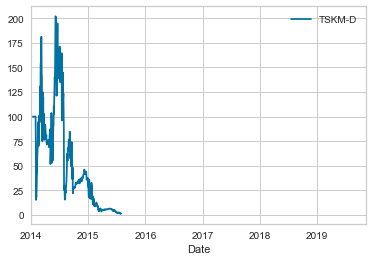

In [8]:
ja = 100 * (Clustering_Returns+1).cumprod()
ja.plot()